# Model Performance
Contains codes to characterize the performance using plots/metrics. Plots directly usable in presentations/Paper

In [55]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization, generate_differential_data_loaders, DifferentialCombinationDataset
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp, interpolate_exp_transform
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

plt.rcParams['figure.dpi'] = 700    # Paper Ready
# plt.rcParams['figure.dpi'] = 150    # For Testing

In [56]:
# Models
# Check the models/model_directory.md for information about saved models & their scalers
model_file_name = 'msat_percep_irsi'
model_file_path = r'../models/' + model_file_name
model_init_params = [60, 8, 1]
# y_columns = ['Fetal Saturation']
y_columns = ['Maternal Saturation']

In [60]:
# Create Inputs
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, 0.8])
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')

data = data.drop(columns='Uterus Thickness')
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data = create_ratio_and_intensity(data, True)
# data = create_ratio(data, True)
# data = create_spatial_intensity(data)
data.dropna(inplace=True)   # Cleanup
x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))
y_scaler = joblib.load(r'../models/' + model_file_name + '_yscaler')
data[y_columns] = y_scaler.fit_transform(data[y_columns])
x_scaler = joblib.load(r'../models/' + model_file_name + '_xscaler')
data[x_columns] = x_scaler.fit_transform(data[x_columns])
model = PerceptronReLU(model_init_params)
model.load_state_dict(torch.load(model_file_path))
model = model.cuda()

# Create prediction table for all data
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    mse = np.square(y_data - predictions)
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "MSE": absolute_error})
combined_table = data.join(error_df)
combined_table.drop(columns=x_columns, inplace=True)
combined_table[y_columns[0]] = y_data    
# We are only predicting a single feature for now!

In [61]:
combined_table.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Truth,Predicted,Absolute Error,MSE
0,2.0,12.0,0.9,0.11,0.100,0.9,0.902396,0.002396,0.002396
1,2.0,12.0,0.9,0.11,0.225,0.9,0.902908,0.002908,0.002908
2,2.0,12.0,0.9,0.11,0.350,0.9,0.903442,0.003442,0.003442
3,2.0,12.0,0.9,0.11,0.475,0.9,0.903998,0.003998,0.003998
4,2.0,12.0,0.9,0.11,0.600,0.9,0.904576,0.004576,0.004576


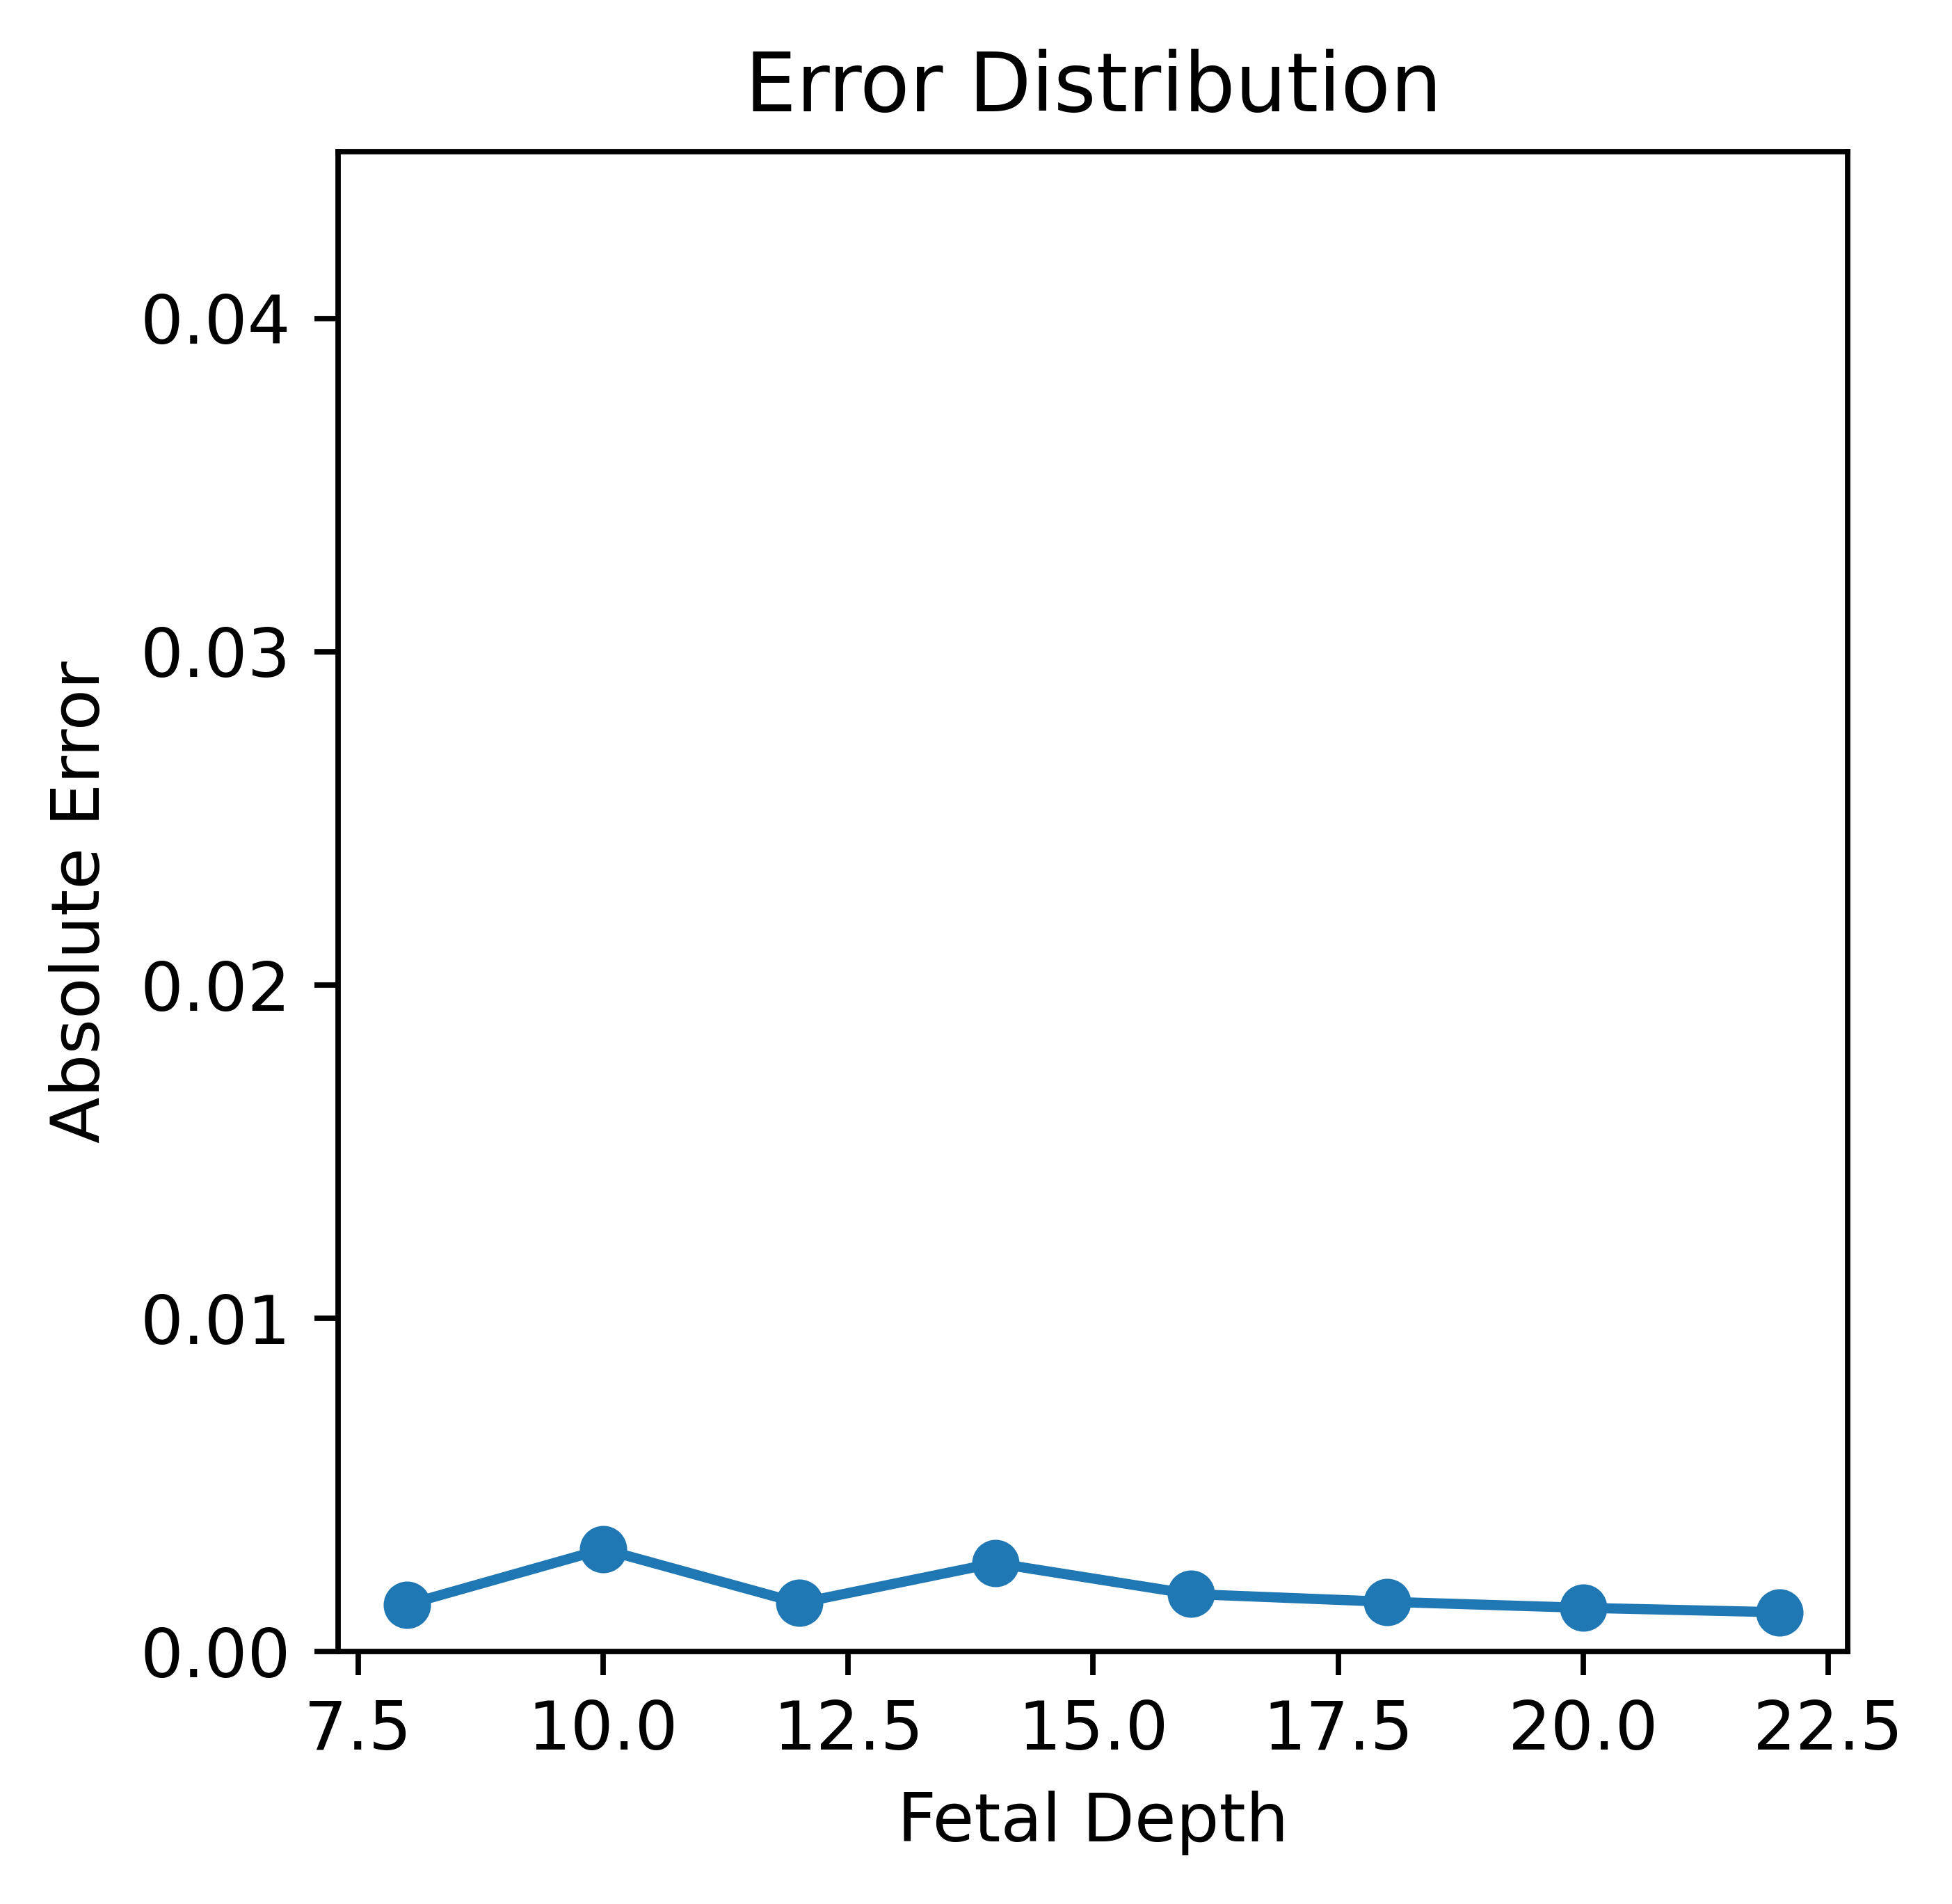

In [62]:
combined_table['Fetal Depth'] = combined_table['Maternal Wall Thickness'] + 6.0
depth_error_dist = combined_table.groupby('Fetal Depth')['Absolute Error'].mean()
# depth_error_dist = combined_table.groupby('Fetal Depth')['MSE'].mean()
plt.figure(figsize=(4, 4))
plt.plot(depth_error_dist, 'o-')
plt.xlabel("Fetal Depth")
plt.ylabel("Absolute Error")
plt.title('Error Distribution')
plt.ylim(0.0, 0.045)
plt.locator_params('y', nbins=6)